In [1]:
# Vanilla Policy Gradient with rewards-to-go v. CartPole-v0
# https://spinningup.openai.com/en/latest/algorithms/vpg.html

In [2]:
import math
import torch
from torch import nn
from torch import tensor
import gym
import matplotlib.pyplot as plt

In [3]:
env = gym.make("CartPole-v0")
env.action_space, env.observation_space

(Discrete(2),
 Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32))

In [4]:
act_dim = env.action_space.n
obs_dim = len(env.observation_space.sample())

In [5]:
# Hyperparameters

n_epochs = 20
steps_per_epoch = 8000
pi_hid_dim = 64
pi_lr = 0.01

In [6]:
# pi, our policy

pi = nn.Sequential(
    nn.Linear(obs_dim, pi_hid_dim),
    nn.Tanh(),
    nn.Linear(pi_hid_dim, pi_hid_dim),
    nn.Tanh(),
    nn.Linear(pi_hid_dim, act_dim)
)

In [7]:
def get_policy(obs):
    logits = pi(obs)
    return torch.distributions.Categorical(logits=logits)

def get_action(obs):
    return get_policy(obs).sample()

def loss(obs, act, weights):        
    logp = get_policy(obs).log_prob(act)
    return -(logp * weights).mean()

In [8]:
def train(n_epochs):
    train_loss, ret_mean, ret_max, ret_min, ret_std = [], [], [], [], []
    optim = torch.optim.Adam(pi.parameters(), lr=pi_lr)
    
    for k in range(n_epochs):
        act, rew, obs, ret = [], [], [], []
        ep = 0
        start = -1
        observation = env.reset()
               
        for t in range(steps_per_epoch):
            # env.render() 
            obs.append(observation)
            action = get_action(torch.from_numpy(observation).float().unsqueeze(dim=0)).item()
            observation, reward, done, _ = env.step(action)
            act.append(action)
            rew.append(reward)
        
            if done or t == steps_per_epoch - 1:
                # print(f"Epoch {k}, Episode {ep} ended after {t - start} steps")
                        
                # Compute rewards-to-go
                for i in range(len(rew) - 2, start, -1):
                    rew[i] += rew[i + 1]
                
                ret.append(rew[start + 1])
                observation = env.reset()
                ep += 1
                start = t
        
        # End of batch 
        optim.zero_grad()  
        epoch_loss = loss(tensor(obs).float(), tensor(act).int(), tensor(rew).float())
        epoch_loss.backward()
        optim.step()
        
        print(f"Epoch {k}: {ep} episodes\nAvg episode return: {sum(ret) / len(ret)}\nLoss: {epoch_loss}\n")
        train_loss.append(epoch_loss)
        mean = sum(ret) / len(ret)
        ret_mean.append(mean)
        ret_std.append(math.sqrt(sum([(mean - rew) ** 2 for rew in ret]) / len(ret)))
        ret_max.append(max(*ret))
        ret_min.append(min(*ret))
        
    env.close()
    return train_loss, ret_mean, ret_std, ret_max, ret_min

Epoch 0: 383 episodes
Avg episode return: 20.887728459530027
Loss: 9.636371612548828

Epoch 1: 317 episodes
Avg episode return: 25.236593059936908
Loss: 11.306453704833984

Epoch 2: 189 episodes
Avg episode return: 42.32804232804233
Loss: 17.92449951171875

Epoch 3: 195 episodes
Avg episode return: 41.02564102564103
Loss: 16.703062057495117

Epoch 4: 150 episodes
Avg episode return: 53.333333333333336
Loss: 19.27981948852539

Epoch 5: 128 episodes
Avg episode return: 62.5
Loss: 21.599468231201172

Epoch 6: 134 episodes
Avg episode return: 59.701492537313435
Loss: 20.655920028686523

Epoch 7: 114 episodes
Avg episode return: 70.17543859649123
Loss: 24.47594451904297

Epoch 8: 70 episodes
Avg episode return: 114.28571428571429
Loss: 35.792171478271484

Epoch 9: 65 episodes
Avg episode return: 123.07692307692308
Loss: 35.96760940551758

Epoch 10: 49 episodes
Avg episode return: 163.26530612244898
Loss: 44.48194122314453

Epoch 11: 49 episodes
Avg episode return: 163.26530612244898
Loss: 4

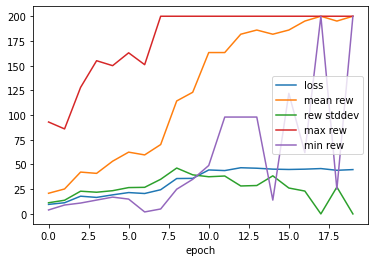

In [9]:
train_loss, ret_mean, ret_std, ret_max, ret_min = train(n_epochs)
plt.plot(train_loss, label="loss")
plt.plot(ret_mean, label="mean rew")
plt.plot(ret_std, label="rew stddev")
plt.plot(ret_max, label="max rew")
plt.plot(ret_min, label="min rew")
plt.xlabel("epoch")
plt.legend()